In [28]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 32
img_height = 180
img_width = 180
nb_channels = 3
data_dir = "Pictures/"

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1979 files belonging to 6 classes.
Using 1584 files for training.


I0000 00:00:1769213859.897171   87396 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2600 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1979 files belonging to 6 classes.
Using 395 files for validation.


In [5]:
test_ds = val_ds.skip(7)
val_ds = val_ds.take(7)

In [6]:
class_names = train_ds.class_names

2026-01-24 01:17:48.833890: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


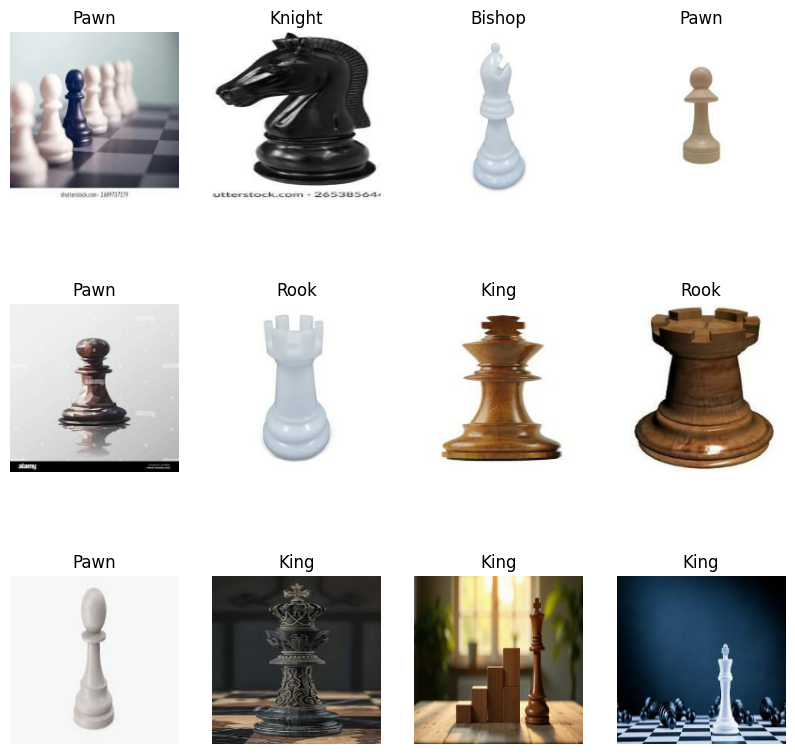

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(height=img_height, width=img_width),
    layers.Rescaling(scale=1./255)
])

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [49]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, nb_channels)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(len(class_names), activation='softmax')
])

/home/khiro/Chess piece recognizer/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
model.build(input_shape=(batch_size, img_width, img_height, nb_channels))

In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 178, 178, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 89, 89, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 87, 87, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 43, 43, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 41, 41, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 20, 20, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 25600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │     1,638,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 6)                │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,695,174 (6.47 MB)

 Trainable params: 1,695,174 (6.47 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [53]:
history = model.fit(
    train_ds,
    epochs=100,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.2216 - loss: 1.7965 - val_accuracy: 0.2277 - val_loss: 1.7687
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.2544 - loss: 1.7521 - val_accuracy: 0.2455 - val_loss: 1.7606
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.2765 - loss: 1.7279 - val_accuracy: 0.3036 - val_loss: 1.7467
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.2961 - loss: 1.7029 - val_accuracy: 0.2902 - val_loss: 1.7384
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.3144 - loss: 1.6960 - val_accuracy: 0.3036 - val_loss: 1.7356
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.3283 - loss: 1.6640 - val_accuracy: 0.2545 - val_loss: 1.7963
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.3340 - loss: 1.6510 - val_accuracy: 0.3125 - val_loss: 1.7215
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.3409 - loss: 1.6402 - val_accuracy: 0.

0.559968888759613


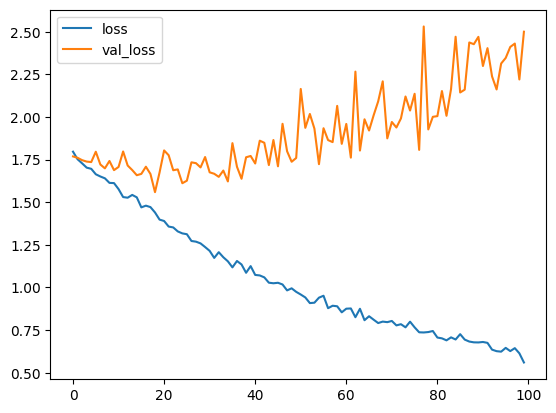

In [54]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
print(min(loss))

0.810606062412262


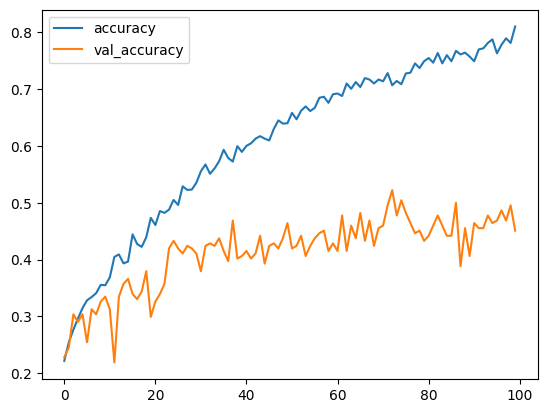

In [55]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(acc, label="accuracy")
plt.plot(val_acc, label="val_accuracy")
plt.legend()
print(max(acc))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


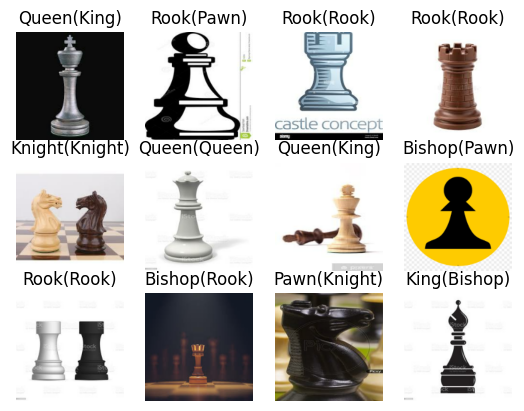

In [60]:
for images, labels in test_ds.take(1):
    p = model.predict(images)
    p = np.argmax(p, axis=1)
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[p[i]] + "(" + class_names[labels[i]] + ")" )
        plt.axis("off")
    

In [59]:
model.evaluate(val_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4777 - loss: 2.4520


[2.4520037174224854, 0.4776785671710968]